# Desafío - Árboles de regresión
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Árboles de regresión.

## Requerimientos
- Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos.
- Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable `Sale_Price`.

### Ejercicio 1: Preparación del ambiente de trabajo
- Importe las librerías clásicas a utilizar.
- Para este ejercicio implementaremos árboles de regresión, por lo que deberá importar la clase `DecisionTreeRegressor`.
- De manera adicional importe las funciones y clases necesarias para generar un desempeño de métricas en problemas de regresión, división de muestras y búsqueda de grilla con validación cruzada.
- Elimine la columna `Unnamed: 0` cuando cargue los datos.

In [38]:
# Utiliza esta celda para importar las librerías y el set de datos
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV
import lec7_graphs as afx
import pickle

import warnings
warnings.simplefilter('ignore')



In [51]:
df = pd.read_csv('ames_housing.csv').drop(columns='Unnamed: 0')
df.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


### Ejercicio 2: Feature engineering
- Identifique si el `dtype` de cada `pd.Series` en nuestra base de datos se considera `object` o no. Para todas las variables que sean `object`, realice lo siguiente:
    - Genere una recodificación $k-1$ en cada variable.
    - Para efectos prácticos sólo necesitan eliminar una de las categorías, no se concentren en especificar la categoría a eliminar.
    - Pueden utilizar la función con la opción `drop_first` para ello.
- Utilizando el método `pd.concat`, concatene a los atributos creados en la base de datos.

_**Tip**_: No se olvide de eliminar los atributos recodificados, de esta forma evitará un aumento artificial del desempeño del modelo.

In [40]:
# Utiliza esta celda para generar el DataFrame solicitado
df_object = df.select_dtypes('object')
df_number = df.select_dtypes(np.number)

df_dummies = pd.get_dummies(df_object, drop_first=True)

df_dummies.shape, df_number.shape

df_work = pd.concat([df_number, df_dummies], axis=1)
df_work.head()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0
2,81,14267,1958,1958,108,1,0,406,1329,1329,...,0,0,0,0,1,0,0,0,1,0
3,93,11160,1968,1968,0,1,0,1045,2110,2110,...,0,0,0,0,1,0,0,0,1,0
4,74,13830,1997,1998,0,3,0,137,928,928,...,0,0,0,0,1,0,0,0,1,0


### Ejercicio 3: Primer modelo
- Genere muestras de entrenamiento y validación con `Sale_Price` como vector objetivo y los atributos de la base de datos como matriz.
- Recuerde definir el porcentaje de casos en la muestra de validación y una semilla pseudoaleatoria.
- Posteriormente, entrene un árbol de regresión en la muestra de entrenamiento _sin modificar los hiper parámetros_.
- Reporte las principales métricas de desempeño
- Comente sobre el desempeño.

In [41]:
# Utiliza esta celda para generar los subsets de datos
X = df_work.drop(columns='Sale_Price')
y = df_work['Sale_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

In [42]:
# Utiliza esta celda para entrenar el modelo solicitado
modelo = DecisionTreeRegressor()
modelo.fit(X_train, y_train)

DecisionTreeRegressor()

In [43]:
# Utiliza esta celda para reportar las métricas solicitadas
y_hat = modelo.predict(X_test)
print(f'''Metricas
RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}
MAE: {median_absolute_error(y_test, y_hat)}
R2 Score: {r2_score(y_test, y_hat)}''')

Metricas
RMSE: 40939.17767095907
MAE: 15500.0
R2 Score: 0.7513404885656273


**Comentarios**

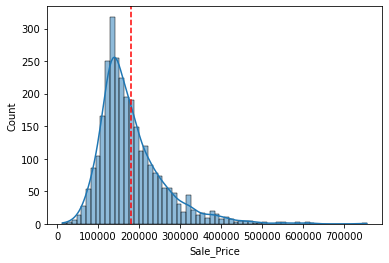

In [44]:
sns.histplot(df['Sale_Price'], kde=True)
plt.axvline(df['Sale_Price'].mean(), ls='--', color='red')

### Ejercicio 4: Importancia relativa
- Implemente la función `plot_importance` utilizado en la lectura para reportar la importancia relativa de los atributos.
- Comente sobre cuáles son los principales 10 atributos que afectan la predicción de `Sale_Price`.
- Separe estos 10 atributos en una nueva base de datos, junto con el vector objetivo.

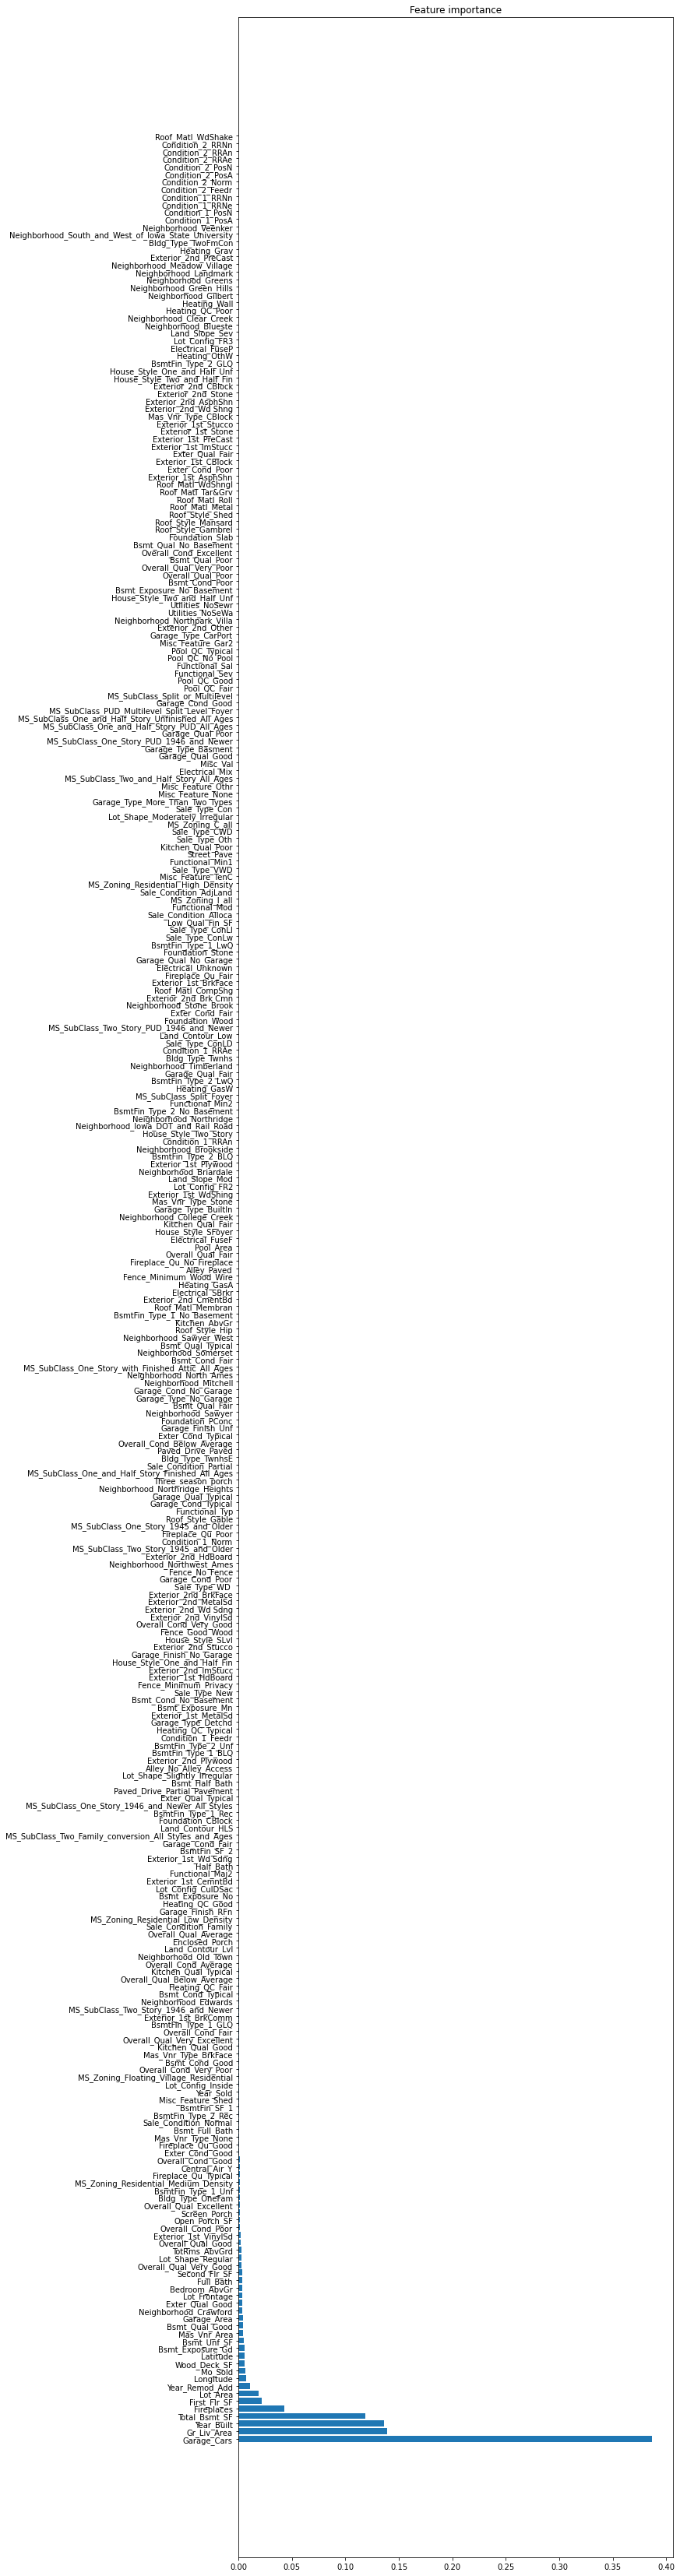

In [45]:
# Utiliza esta celda para definir la función solicitada
plt.figure(figsize=(10,60))
afx.plot_importance(modelo, X_train.columns)

In [46]:
# Utiliza esta celda para realizar el llamado de la función
hold_importance = modelo.feature_importances_
sort_importance = np.argsort(hold_importance)[::-1]

names = [X_train.columns[i] for i in sort_importance][:10]

df_work_10 = df_work[names + ['Sale_Price']]

df_work_10.head()

,Garage_Cars,Gr_Liv_Area,Year_Built,Total_Bsmt_SF,Fireplaces,First_Flr_SF,Lot_Area,Year_Remod_Add,Longitude,Mo_Sold,Sale_Price
0,2,1656,1960,1080,2,1656,31770,1960,-93.619754,5,215000
1,1,896,1961,882,0,896,11622,1961,-93.619756,6,105000
2,1,1329,1958,1329,0,1329,14267,1958,-93.619387,6,172000
3,2,2110,1968,2110,2,2110,11160,1968,-93.617320,4,244000
4,2,1629,1997,928,1,928,13830,1998,-93.638933,3,189900


### Ejercicio 5: Refactorización del modelo y picklingpd.get_dummies
- En función de los atributos seleccionados en el ejercicio anterior, vuelva a generar conjuntos de entrenamiento y validación.
- Dentro de los datos de entrenamiento genere una búsqueda de grilla con `GridSearchCV` utilizando los siguientes hiper parámetros:
    - **Máximo de atributos**: Evalúe todos los posibles atributos.
    - **Máximo de profundidad**: Entre 1 a 32.
    - **Validaciones cruzadas**: 5.
- Reporte la mejor combinación de hiper parámetros y su desempeño asociado.
- Compare el desempeño en la muestra de validación con el modelo por defecto.

In [47]:
# Utiliza esta celda para generar los nuevos sets de datos

X = df_work_10.drop(columns='Sale_Price')
y = df_work_10['Sale_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

In [48]:
# Utiliza esta celda para generar y entrenar el objeto GridSearchCV
grilla = GridSearchCV(DecisionTreeRegressor(),
                param_grid = {'max_features': np.linspace(1, X_train.shape[1]),
                        'max_depth': np.linspace(1,32, num=32, endpoint=True) }, cv=5)

In [55]:
# Utiliza esta celda para mostrar mejores hiperparámetros y puntaje asociado

grilla.fit(X_train, y_train)

ValueError: 
All the 8000 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dmard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dmard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 1342, in fit
    super().fit(
  File "c:\Users\dmard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 238, in fit
    check_scalar(
  File "c:\Users\dmard\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 1452, in check_scalar
    raise TypeError(
TypeError: max_depth must be an instance of int, not float64.


In [ ]:
# Utiliza esta celda para mostrar las métricas de desempeño

**Comentarios**

### Pickling
- Ahora generamos una serialización de nuestro modelo depurado, y nuestros conjuntos de entrenamiento y validación depurados. Para ello importe el módulo `pickle`.
- `pickle` contiene la función `dump`, que permite guardar el modelo desarrollado. 
- La forma canónica para desarrollar el pickling es:
```python
pickle.dump(<OBJETO_CON_EL_MODELO>,open('nombre-apellido-actividad07.sav', 'wb'))
```
- Envíe su modelo y conjuntos de entrenamiento a un compañero.

In [ ]:
# Utiliza esta celda para importar pickle y serializar el modelo

### Serialización de datos
- Los `pd.DataFrame` se pueden guardar como archivos csv con el método `.to_csv('nombre_archivo.csv', index=False)`
- El parámetro `index=False` evita que se genere la columna `Unnamed: 0`

In [ ]:
# Utiliza esta celda para guardar archivos csv de las muestras generadas con train test split para el último modelo